In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [33]:
fn = './data/web_traffic/train_1.csv'
df = pd.read_csv(fn)

In [34]:
data = df.iloc[40157]
page = data['Page']
print(page)
ts   = data.values[1:]

Internet_en.wikipedia.org_all-access_all-agents


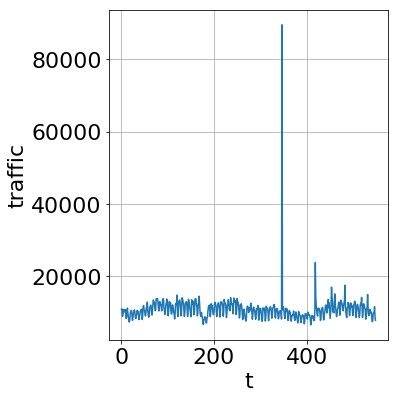

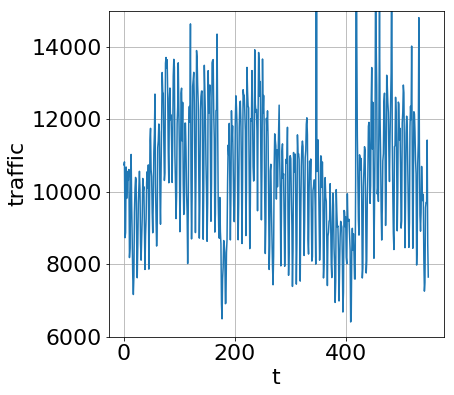

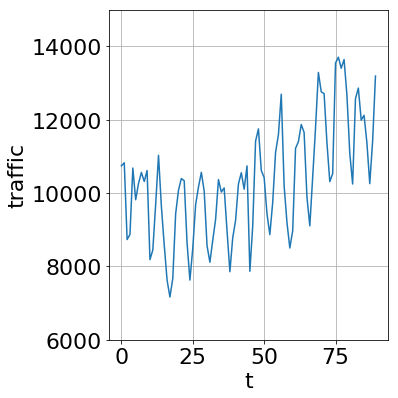

In [35]:
plt.figure(figsize=(6,6))
plt.plot(ts)
plt.xlabel('t')
plt.ylabel('traffic')
plt.grid(True)
plt.tight_layout()
plt.savefig('internet_traffic_long.png', dpi=300)
plt.show()

plt.figure(figsize=(6,6))
plt.plot(ts)
plt.xlabel('t')
plt.ylabel('traffic')
plt.grid(True)
plt.ylim(6000,15000)
plt.show()

plt.figure(figsize=(6,6))
plt.plot(ts[:90])
plt.xlabel('t')
plt.ylabel('traffic')
plt.grid(True)
plt.ylim(6000,15000)
plt.tight_layout()
plt.savefig('internet_traffic_short.png', dpi=300)
plt.show()

In [36]:
Ntrain = 390
ts_train = ts[:Ntrain]
ts_test  = ts[Ntrain:]

In [37]:
mu = np.mean(ts_train)
std = np.std(ts_train)

ts_train[ts_train > mu+2*std] = mu+2*std
ts_train[ts_train < mu-2*std] = mu-2*std

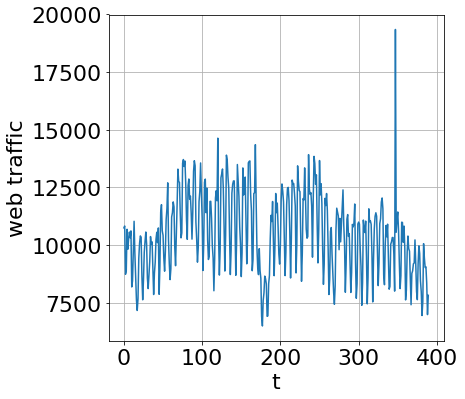

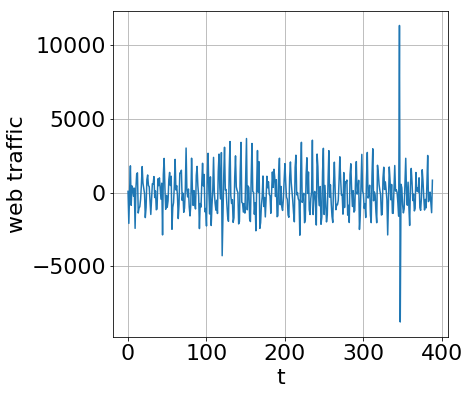

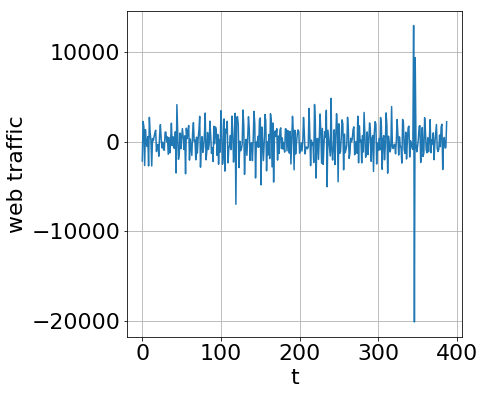

In [38]:
plt.figure(figsize=(6,6))
plt.plot(ts_train)
plt.xlabel('t')
plt.ylabel('web traffic')
plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
plt.plot(np.diff(ts_train))
plt.xlabel('t')
plt.ylabel('web traffic')
plt.grid(True)
plt.show()

plt.figure(figsize=(6,6))
plt.plot(np.diff(np.diff(ts_train)))
plt.xlabel('t')
plt.ylabel('web traffic')
plt.grid(True)
plt.show()

In [39]:
from statsmodels.tsa.stattools import acf, pacf
lag    = 365
alpha  = 0.2

In [40]:
acf_calc, acf_confint  = acf(ts_train, nlags=lag, fft=True, alpha=alpha)

pacf_calc, pacf_confint = pacf(ts_train, nlags=lag, alpha=alpha)

/home/gabriel/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


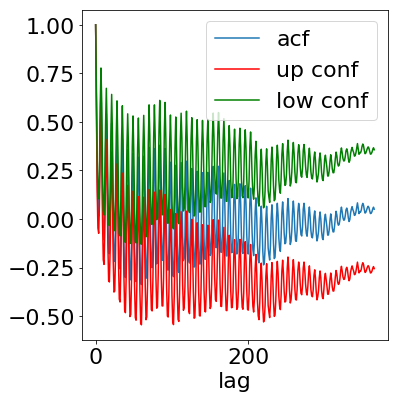

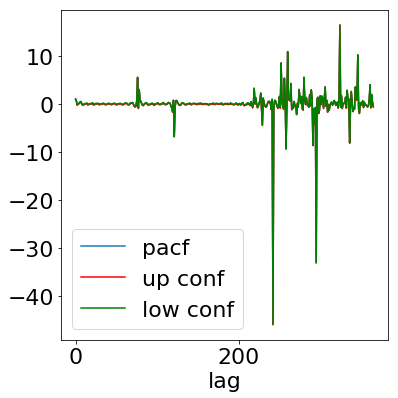

In [41]:
plt.figure(figsize=(6,6))
plt.plot(acf_calc, label='acf')
plt.plot(acf_confint[:,0], color='r', label='up conf')
plt.plot(acf_confint[:,1], color='g', label='low conf')
plt.xlabel('lag')
plt.legend()
plt.tight_layout()
plt.savefig('internet_acf.png',dpi=300)
plt.show()

plt.figure(figsize=(6,6))
plt.plot(pacf_calc, label='pacf')
plt.plot(pacf_confint[:,0], color='r', label='up conf')
plt.plot(pacf_confint[:,1], color='g', label='low conf')
plt.xlabel('lag')
plt.legend()
plt.tight_layout()
plt.savefig('internet_pacf.png',dpi=300)
plt.show()

In [42]:
X_train = []
Y_train = []

for i in range(lag, Ntrain):
    x = ts_train[i-lag:i]
    y = ts_train[i]
    
    X_train.append(x)
    Y_train.append(y)
    
X_train = np.array(X_train)
Y_train = np.array(Y_train)

print(X_train.shape)
print(Y_train.shape)

(25, 365)
(25,)


In [72]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

model_linear = LinearRegression()
model_ridge  = Ridge(alpha=100)
model_lasso  = Lasso(alpha=50)
model_gb     = GradientBoostingRegressor()
model_rf     = RandomForestRegressor()
model_svr    = SVR(kernel='rbf')
model_nn     = MLPRegressor(hidden_layer_sizes=(100,50,25,10), 
                            activation='relu', solver='adam', max_iter=100000)

models = [model_linear, model_ridge, model_lasso, model_gb, model_rf, model_svr, model_nn]
labels = ['linear', 'ridge', 'lasso', 'gradient boosting', 'RF', 'SVR', 'NN']
colors = ['b','r','g','orange', 'teal', 'purple', 'magenta']

for m in models:
    m.fit(X_train, Y_train)

/home/gabriel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3391.705683656772, tolerance: 2169.929016
  positive)
/home/gabriel/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/home/gabriel/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


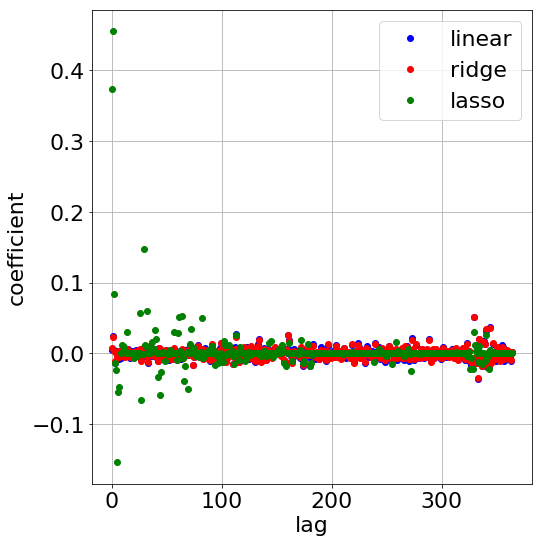

In [73]:
plt.figure(figsize=(8,8))

for m,l,c in zip(models[:3],labels[:3],colors[:3]):
    plt.plot(m.coef_, color=c, linestyle='', marker='o', label=l)

plt.legend()
plt.xlabel('lag')
plt.ylabel('coefficient')
plt.grid(True)
plt.tight_layout()
plt.savefig('internet_linear_coef.png', dpi=300)
plt.show()

In [74]:
horizon = 159
predictions = []
for i,m in enumerate(models):
    Yhat = np.zeros(lag+horizon)
    Yhat[:lag] = ts_train[-lag:]
    
    for j in range(lag,lag+horizon):
        x = Yhat[j-lag:j]
        p = m.predict(x[np.newaxis,:])
        Yhat[j] = p[0]
        
    predictions.append(Yhat)

In [75]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
m     = 183

hw = ExponentialSmoothing(ts_train.astype(float), trend='add', seasonal='add', seasonal_periods=m)
model_hw = hw.fit()

Yhat = model_hw.predict(start=Ntrain, end=Ntrain+horizon-1)

Yhat_hw = np.zeros((lag+horizon))
Yhat_hw[:lag] = ts_train[-lag:]
Yhat_hw[lag:] = Yhat

predictions.append(Yhat_hw)
labels.append('HW')
colors.append('gray')

/home/gabriel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:711: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


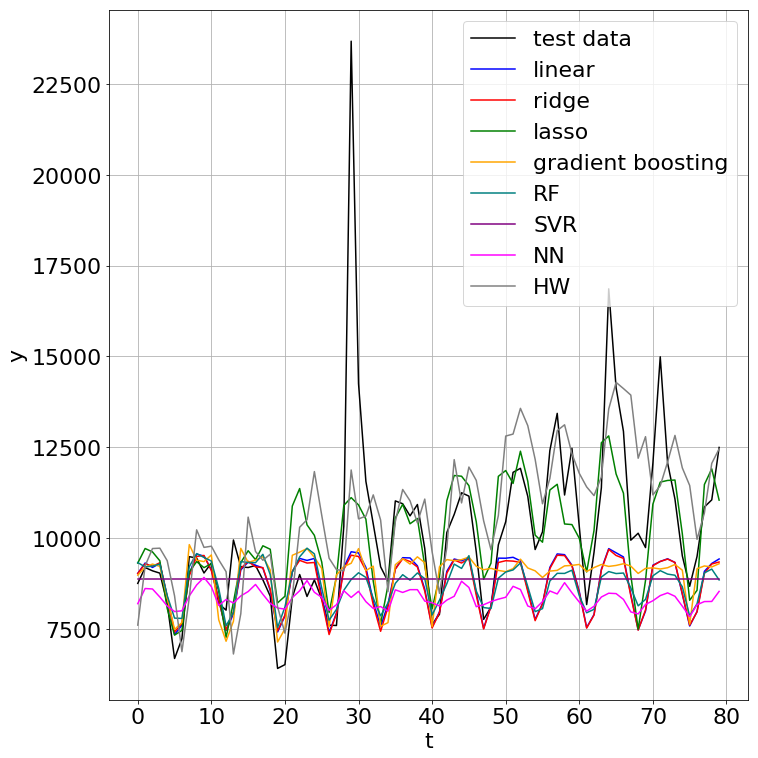

In [76]:
val_horizon = 80

plt.figure(figsize=(11,11))

plt.plot(ts_test[:val_horizon], color='k', label='test data')

for p,l,c in zip(predictions,labels,colors):
    plt.plot(p[lag:lag+val_horizon], color=c, label=l)

plt.legend()
plt.xlabel('t')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
plt.savefig('internet_forecast_val.png', dpi=300)
plt.show()

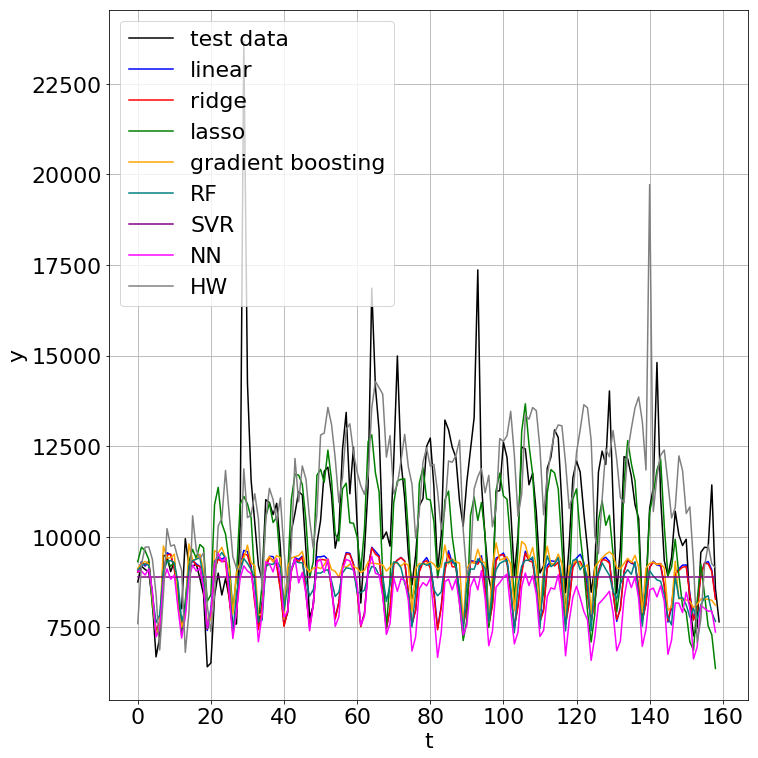

In [66]:
plt.figure(figsize=(11,11))

plt.plot(ts_test, color='k', label='test data')

for p,l,c in zip(predictions,labels,colors):
    plt.plot(p[lag:lag+horizon], color=c, label=l)

plt.legend()
plt.xlabel('t')
plt.ylabel('y')
plt.grid(True)
plt.tight_layout()
plt.savefig('internet_forecast.png', dpi=300)
plt.show()

In [50]:
for p,l in zip(predictions,labels):
    e = np.mean( (p[lag:lag+horizon]-ts_test[:horizon])**2 )
    
    print("{} - error={:.0f}".format(l,np.sqrt(e)))

linear - error=2497
ridge - error=2531
lasso - error=1789
gradient boosting - error=2452
RF - error=2591
SVR - error=2696
NN - error=3330
HW - error=2210
